In [1]:
import torch
import torch.nn as nn
import random
from scipy.stats import bernoulli
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

from numpy import asarray
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import exp
from torchvision.models import resnet50, ResNet50_Weights
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset



In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
    nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.dense12 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.dense22 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.dense32 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.dense42 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    
    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.dense52 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.dense62 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.dense72 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t, c): ##her skal jeg have en class
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))  ####eventuelt læg de to embeddings sammen
    embed_clas = self.act(self.embed(c))  
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    h1 += self.dense12(embed_clas)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 += self.dense22(embed_clas)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 += self.dense32(embed_clas)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 += self.dense42(embed_clas)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)
    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h += self.dense52(embed_clas)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h += self.dense62(embed_clas)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h += self.dense72(embed_clas)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))
    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch visionUniversitet
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [4]:
class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):        
        super(DDPM, self).__init__()
        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t, c: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T),c.squeeze()/11) #t.squeeze()/11 # 10 klasser + NaN class
                                    ).reshape(-1, 28*28)
        # Total number of time steps
        self.T = T
        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon,c,w):
        ydumb =  torch.Tensor([11]).repeat(c.shape[0]).to(device)#### Could be more effecient
        eps = self.network(xt, t,ydumb) + w * ( self.network(xt, t,c) - self.network(xt, t,ydumb))
        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*eps)
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape, c,w):
        xT = torch.randn(shape).to(self.beta.device)
        xt = xT
        for t in range(self.T, 0, -1):
            c = torch.tensor(c).expand(xt.shape[0], 1).to(self.beta.device)
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise,c,w)
        return xt

    
    def elbo_simple(self, x0,c):
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        epsilon = torch.randn_like(x0)
        xt = self.forward_diffusion(x0, t, epsilon)        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t,c))

    
    def loss(self, x0,c):
        return -self.elbo_simple(x0,c).mean()

# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256

# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
mnist_unet01 = ScoreNet((lambda t: torch.ones(1).to(device)))
mnist_unet01.load_state_dict(torch.load('ddpmgunet01.pth'))
# Construct model
model01 = DDPM(mnist_unet01, T=T).to(device)
model01.load_state_dict(torch.load('ddpmg01.pth'))

mnist_unet02 = ScoreNet((lambda t: torch.ones(1).to(device)))
mnist_unet02.load_state_dict(torch.load('ddpmgunet02.pth'))
# Construct model
model02 = DDPM(mnist_unet02, T=T).to(device)
model02.load_state_dict(torch.load('ddpmg02.pth'))


mnist_unet05 = ScoreNet((lambda t: torch.ones(1).to(device)))
mnist_unet05.load_state_dict(torch.load('ddpmgunet05.pth'))
# Construct model
model05 = DDPM(mnist_unet05, T=T).to(device)
model05.load_state_dict(torch.load('ddpmg05.pth'))

/tmp/ipykernel_59228/2474343953.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mnist_unet01.load_state_dict(torch.load('ddpmgunet01.pth'))
/tmp/ipykernel_59228/24743439

<All keys matched successfully>

In [6]:
def plotrow(samples, nsamples):
    grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
    plt.gca().set_axis_off()
    plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
    plt.show()   


def plotmodel (model, n, ctoken, weight):
    nsamples= n
    samples = model.sample((nsamples,28*28),ctoken,weight).cpu()
    samples = (samples+1)/2 
    samples = samples.clamp(0.0, 1.0)
    plotrow(samples = samples, nsamples= nsamples)



/tmp/ipykernel_59228/1245185393.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c).expand(xt.shape[0], 1).to(self.beta.device)


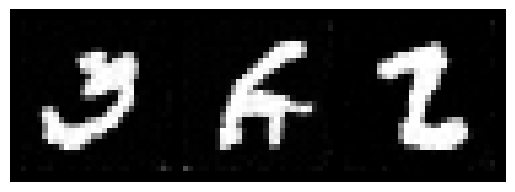

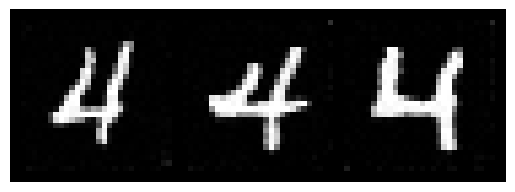

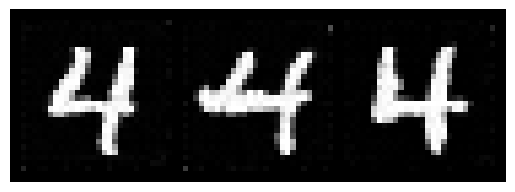

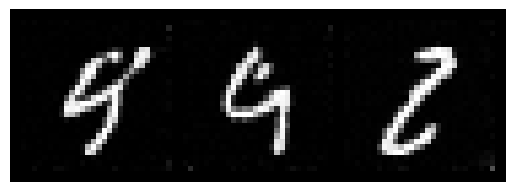

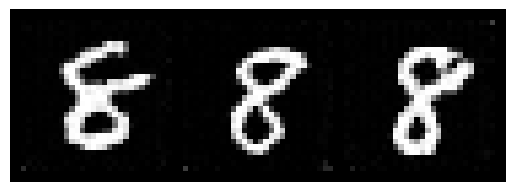

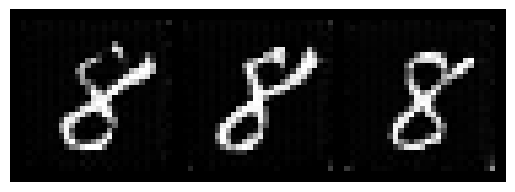

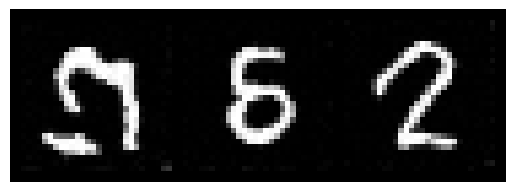

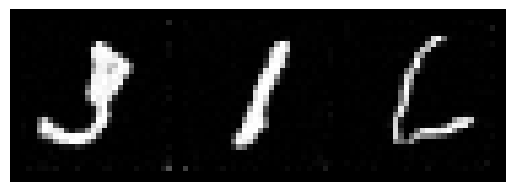

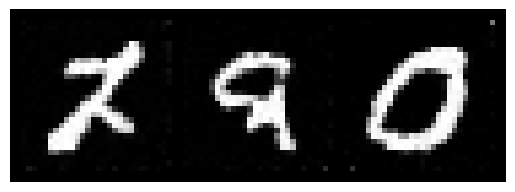

In [7]:
print ("pu= 0.1, c=4, w=3")
plotmodel(model01, 3, 4, 3)
print ("pu= 0.1, c=4, w=10")
plotmodel(model01, 3, 4, 10)
print ("pu= 0.1, c=8, w=3")
plotmodel(model01, 3, 8, 3)
print ("pu= 0.1, c=8, w=10")
plotmodel(model01, 3, 8, 10)
print ("pu= 0.1, c=11, w=10")
plotmodel(model01, 3, 11, 10)
print ("pu= 0.1, c=8, w=0")
plotmodel(model01, 3, 8, 0)

/tmp/ipykernel_59228/1245185393.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c).expand(xt.shape[0], 1).to(self.beta.device)


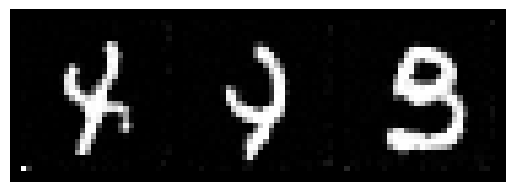

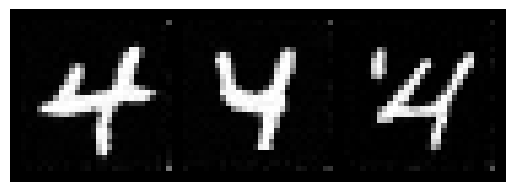

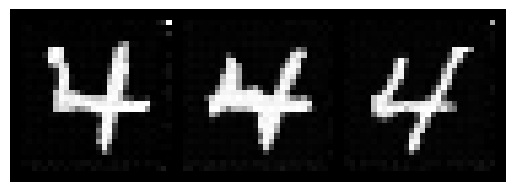

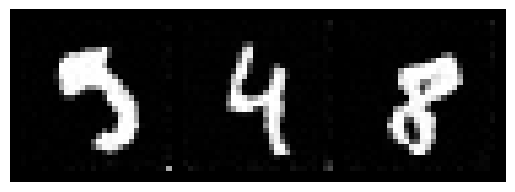

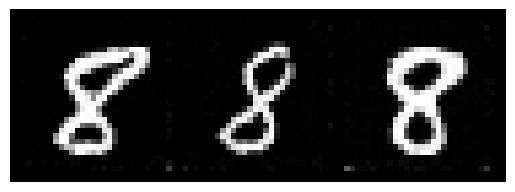

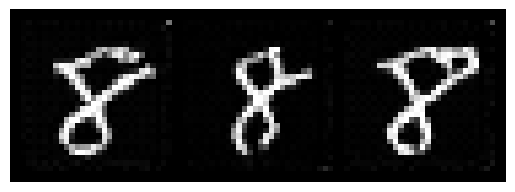

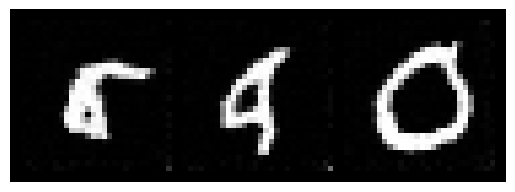

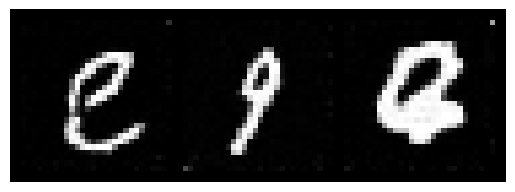

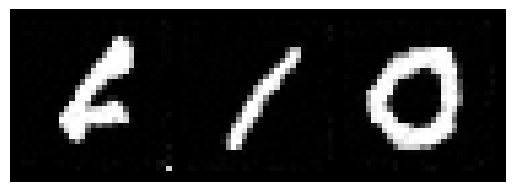

In [8]:
print ("pu= 0.2, c=4, w=3")
plotmodel(model02, 3, 4, 3)
print ("pu= 0.2, c=4, w=10")
plotmodel(model02, 3, 4, 10)
print ("pu= 0.2, c=8, w=3")
plotmodel(model02, 3, 8, 3)
print ("pu= 0.2, c=8, w=10")
plotmodel(model02, 3, 8, 10)
print ("pu= 0.2, c=11, w=10")
plotmodel(model02, 3, 11, 10)
print ("pu= 0.2, c=8, w=0")
plotmodel(model02, 3, 8, 0)

/tmp/ipykernel_59228/1245185393.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c).expand(xt.shape[0], 1).to(self.beta.device)


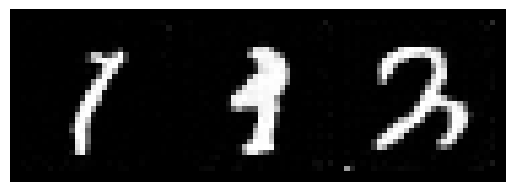

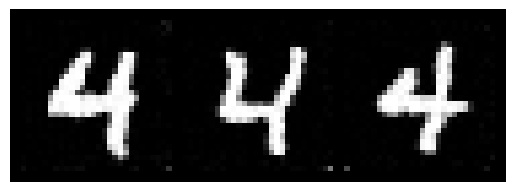

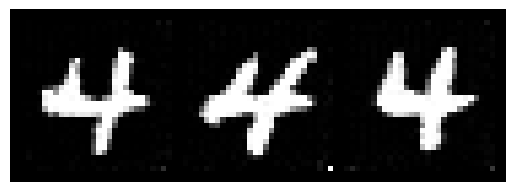

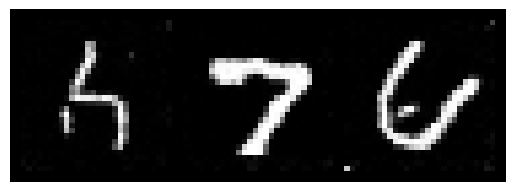

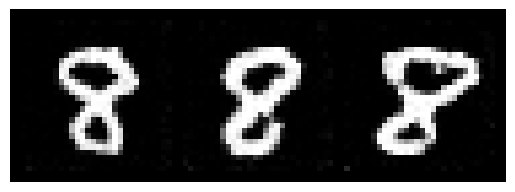

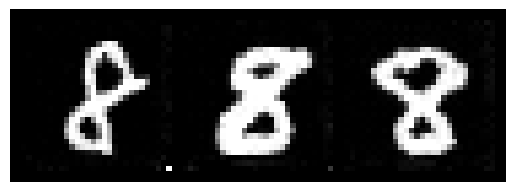

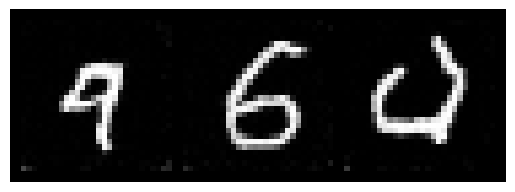

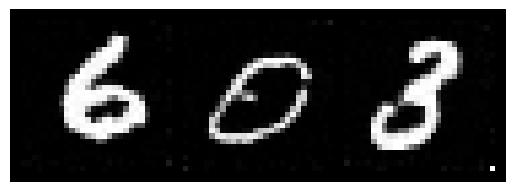

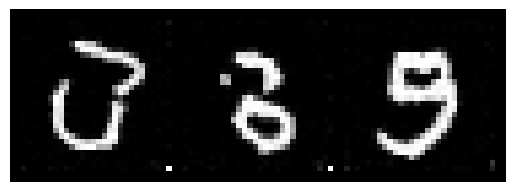

In [9]:
print ("pu= 0.5, c=4, w=3")
plotmodel(model05, 3, 4, 3)
print ("pu= 0.5, c=4, w=10")
plotmodel(model05, 3, 4, 10)
print ("pu= 0.5, c=8, w=3")
plotmodel(model05, 3, 8, 3)
print ("pu= 0.5, c=8, w=10")
plotmodel(model05, 3, 8, 10)
print ("pu= 0.5, c=11, w=10")
plotmodel(model05, 3, 11, 10)
print ("pu= 0.5, c=8, w=0")
plotmodel(model05, 3, 8, 0)

In [10]:
def inceptionscore(p_yx, eps=1E-16):
	p_y = expand_dims(p_yx.mean(axis=0), 0)
	kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
	sum_kl_d = kl_d.sum(axis=1)
	avg_kl_d = mean(sum_kl_d)
	is_score = exp(avg_kl_d)
	return is_score


In [11]:
def experiment(numsamples, weight, classifier, sampler):
    samples = sampler.sample((numsamples,28*28),8,weight).cpu()
    samples = (samples+1)/2 
    samples = samples.clamp(0.0, 1.0)
    print(samples[0])
    p_yx = classifier(samples[0].reshape(-1, 1, 224, 224))
    is_score = inceptionscore(p_yx)
    return is_score

In [12]:
modelc = resnet50(weights=None)
modelc.fc = nn.Linear(modelc.fc.in_features, 10)  
modelc.load_state_dict(torch.load( "10epochresnet1.pt"))
model = modelc.to(device)

/tmp/ipykernel_59228/268409959.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelc.load_state_dict(torch.load( "10epochresnet1.pt"))


In [13]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),             
    transforms.Grayscale(3),                     
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255), 
    transforms.Lambda(lambda x: (x - 0.5) * 2.0)  
])
batch_size = 32
dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=False, transform=transform),batch_size=batch_size,shuffle=True)

Images= torch.tensor(model02.sample((992,28*28),7,0.1)).cpu()
target = torch.tensor([8]*992)
Images =(Images+1)/2 
Images = Images.clamp(0.0, 1.0)

class CustomImageDataset(Dataset):
    def __init__(self, labels, images, transform=None):
        self.labels = labels
        self.images = images
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img = self.images[idx]
        target = self.labels[idx]
        img = (img * 255).byte() 
        img = Image.fromarray(img.reshape(28,28).numpy(), mode="L")
        if self.transform is not None:
            img = self.transform(img)
        return img, target

dataloader_t = torch.utils.data.DataLoader(CustomImageDataset(target, Images, transform=transform), batch_size=32, shuffle=True)


Marrginals = np.zeros(10)
Labels = np.zeros(10)
Margs2 = np.zeros(10)


margs2 = []


model.eval()
aaaa = 0
for image, label in dataloader_t:
    image = image.to(device)
    results = model(image)
    softer = torch.softmax(results, dim=1).cpu().detach().numpy()
    Marrginals += np.sum(softer,axis=0)
    intermediate =np.zeros(10)
    uncount = np.unique(np.argmax(softer,axis=1),return_counts=True)
    #print(uncount)
    for i, idx in enumerate(uncount[0]):
        mew =uncount[1][i]
        Labels[idx] += mew
    margs2.append(softer)



/tmp/ipykernel_59228/1245185393.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c = torch.tensor(c).expand(xt.shape[0], 1).to(self.beta.device)
/tmp/ipykernel_59228/2457498882.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Images= torch.tensor(model02.sample((992,28*28),7,0.1)).cpu()


In [14]:
test = np.array(margs2).reshape(-1,10)
inceptionscore(test)

7.2558146

In [15]:
Marrginals


array([ 74.40177859,  86.59729698, 125.36124575,  79.35714063,
        71.30898946,  99.02419764,  63.04696339, 143.47290254,
       127.59494707, 121.83453202])

In [16]:
Labels

array([ 76.,  86., 127.,  75.,  74.,  99.,  59., 149., 129., 118.])

In [17]:
## 05, 9984, w11,c0 = inc7.867286 L[1090.,  443., 1147.,  941.,  781., 1037., 1078.,  819., 1413.,1235.], M[1074.87380897,  443.84543573, 1138.66734613,  945.91913356,784.76158282, 1022.75437452, 1087.24370515,  812.34048105,1440.32735717, 1233.26661023]
## 02, 9984, w11,c0 = inc7.758951  L[ 783.  797. 1191.  839.  764. 1021.  974.  936. 1383. 1296.], M[ 774.96809188  803.21491529 1189.05144751  847.22906472  759.291075721019.23450698  977.26531453  926.97815027 1388.75051075 1298.01672992]
## 01,  9984, w11,c0 = inc7.596831  L[ 984.  708. 1234. 1055.  625.  985.  864.  961. 1478. 1090.], M[ 978.61510494  693.77996466 1238.24022508 1077.49460599  628.53812312 969.68472415  876.43635325  939.58434962 1473.76162899 1107.86477476]

#alle er 02 992
# c4, w3 , IS 1.0158604, M[9.14554317e-04, 1.31661179e-03, 5.48751523e-02, 2.58897636e-04, 9.89762289e+02, 2.32008527e-02, 3.20213470e-03, 8.38938044e-01,6.06521536e-03, 1.30898097e+00, L [  0.,   0.,   0.,   0., 990.,   0.,   0.,   1.,   0.,   1.]
# c4, w1 IS 2.064914, L[  3.,  22.,  14.,   5., 794.,   5.,  10.,  23.,  20.,  96.], IS, M[  3.65402198,  23.10517972,  14.55023521,   5.46638261, 786.2123909 ,   5.26430612,  11.5335885 ,  22.8150639 ,23.32563034,  96.07320043]
# c4, w0.5 IS 5.183058, L[ 42.,  59.,  37.,  28., 379.,  52.,  50.,  62.,  95., 188.] ,  IS, M[ 39.31310181,  58.32266428,  37.73805947,  27.45305047, 379.5146389 ,  52.4145424 ,  49.98398673,  62.50474741, 95.53566608, 189.21953773]
# c4, w0.1 IS 7.089525,L [ 68.,  60., 113.,  70.,  96., 111.,  84., 111., 137., 142.]),  IS, M[ 64.96757297,  62.94574855, 112.58474246,  75.31509727,95.71327247, 112.0472855 ,  85.22419912, 108.21339244,137.44275707, 137.54591238]


# c1, w0.1 , IS, M
# c1, w0.5 , IS, M
# c1, w1 L ,  IS, M
# c1, w3 L ,  IS, M

# c9, w3 , IS1.0395116, M[1.31082626e+00, 7.57290578e-03, 1.64815339e-01, 5.06168577e-02, 5.47695134e-02, 1.43538031e+00, 1.06234250e-01, 1.41819337e+00,2.16399229e+00, 9.85287615e+02], L [  1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1., 988.]
# c9, w1 , IS2.1260743, M[  9.11096856,   5.34596816,   9.45520284,  13.14214322,18.81080664,  25.45697429,   3.41885154,  55.7438764 ,64.86257201, 786.65265274] L [  8.,   5.,   9.,  13.,  18.,  27.,   3.,  58.,  58., 793.]
# c9, w0.5 L ,  IS 4.812269, M[ 38.8679964 ,  29.38039424,  49.08564209,  49.63331288,57.02590223,  69.18777928,  19.47074284, 116.00421768,142.92653394, 420.41747284] L[ 40.,  29.,  47.,  48.,  58.,  70.,  19., 119., 141., 421.]
# c9, w0.1 L ,  IS7.295546, [ 70.80666366,  76.05819075, 118.76730633,  78.19337916,72.6939941 ,  98.26101334,  61.58108045, 125.41675591,138.41015041, 151.81146431] L[ 74.,  79., 117.,  75.,  72.,  96.,  60., 129., 136., 154.]


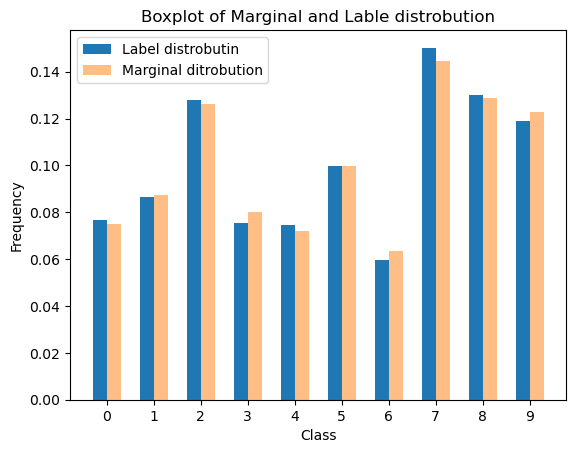

In [18]:
xxxx = [0,1,2,3,4,5,6,7,8,9]
# fauxmargin = [1.31082626e+00, 7.57290578e-03, 1.64815339e-01, 5.06168577e-02, 5.47695134e-02, 1.43538031e+00, 1.06234250e-01, 1.41819337e+00,2.16399229e+00, 9.85287615e+02]
# fauxlabel =  [  1.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   1., 988.]
# fauxmargin = [  9.11096856,   5.34596816,   9.45520284,  13.14214322,18.81080664,  25.45697429,   3.41885154,  55.7438764 ,64.86257201, 786.65265274] 
# fauxlabel = [  8.,   5.,   9.,  13.,  18.,  27.,   3.,  58.,  58., 793.]
barwidth = 0.3 
br2 = [x + barwidth for x in xxxx] 
br3 = [x + barwidth for x in br2] 

plt.bar(xxxx,Labels/np.sum(Labels), alpha=1, width=barwidth, label='Label distrobutin')
plt.bar(br2,Marrginals/np.sum(Marrginals), alpha=0.5,width=barwidth, label='Marginal ditrobution')
plt.title("Boxplot of Marginal and Lable distrobution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([r + barwidth/2 for r in range(len(Labels))], range(10))
plt.legend()
plt.show()